In [3]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
%matplotlib inline
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean*2      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'text.fontsize': 14,
          'legend.fontsize': 10,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


failed: sc.D2R = (PI/180.0)
failed: sc.R2D = (180.0/PI)
failed: sc.MU0 = (PI*4E-7)
failed: sc.T_STEP = (1.0*((1.0*T_MAX)/NUM_STEPS))
failed: sc.E_EXP_BOT = log10(E_MIN)
failed: sc.E_EXP_TOP = log10(E_MAX)
failed: sc.DE_EXP = ((E_EXP_TOP
failed: sc.NUMLATS = ((EALimN
phi_N range: 0, 1019.5
phi_S range: nan, nan


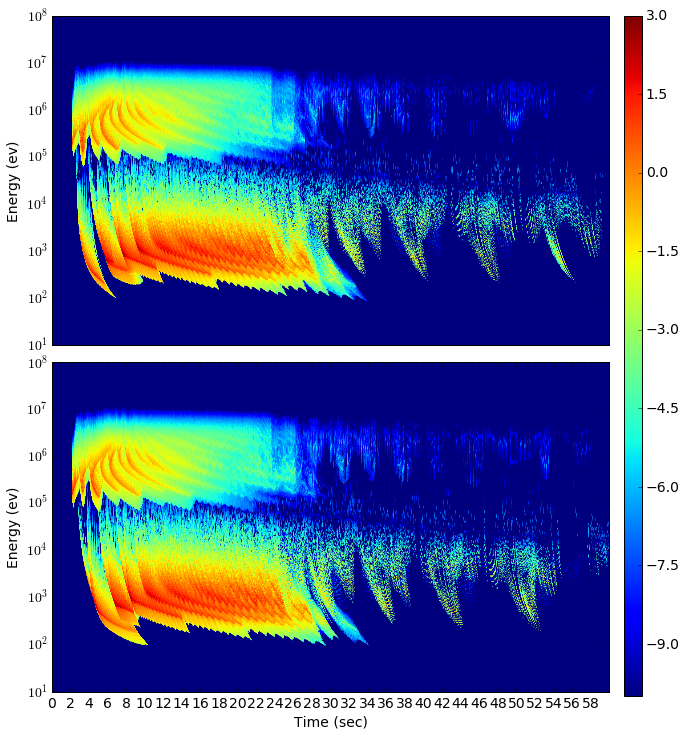

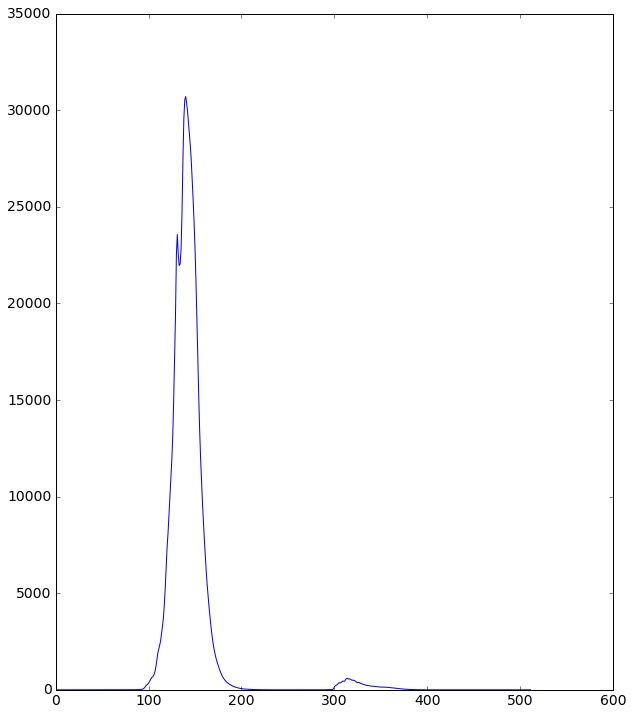

In [5]:
#import sim_consts as sc
from load_sim_constants import load_sim_constants


L = 3.04
directory = '/Users/austin/FUSE/shared/users/asousa/WIPP/WIPPv4/out_full/pwr_-100000/in_25/out_3.04/' 
N_file = os.path.join(directory,"phi_%g_N"%(L))

clims = [-2,2]

sc = load_sim_constants('codesrc/consts.h')


def load_phi(directory, L):
    ''' Loads North and South phi files'''
    # Binary files -- little-endian, 4-byte floats 
    dt = np.dtype('<f4')
    
    phi_N = np.fromfile(os.path.join(directory,"phi_%g_N"%(L)),dtype=dt)
    phi_S = np.fromfile(os.path.join(directory,"phi_%g_S"%(L)),dtype=dt)

    print "phi_N range: %g, %g"%(np.min(phi_N), np.max(phi_N)) 
    print "phi_S range: %g, %g"%(np.min(phi_S), np.max(phi_S)) 

    phi_N = phi_N.reshape(sc.NUM_E, sc.NUM_STEPS, order='c')
    phi_S = phi_S.reshape(sc.NUM_E, sc.NUM_STEPS, order='c')

    return phi_N, phi_S
    
    
def plot_et(N, S, clims=[-7,0],filename=None):
    ''' plot energy vs time spectra for N, S arrays (phi, p, alpha, etc)
        clims are log10 scale
    '''
    
    tvec = np.linspace(sc.T_STEP,sc.T_MAX,sc.NUM_STEPS)

    pN_P = np.log10(N)
    np.clip(pN_P,clims[0],clims[1],out=pN_P)

    pS_P = np.log10(S)
    np.clip(pS_P,clims[0],clims[1],out=pS_P)

    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    # The goods
    p1 = ax1.imshow(pN_P,origin='lower',aspect='auto')
    p1.set_clim(clims)
    p2 = ax2.imshow(pS_P,origin='lower',aspect='auto')
    p2.set_clim(clims)

    # Colorbar
#    cax = fig.add_axes([0.77, 0.12, 0.025, 0.78])
    cax = fig.add_axes([0.92, 0.12, 0.025, 0.78])
    fig.colorbar(p1,cax=cax)

    # Label axes
    
    tlabels = np.arange(0,np.floor(sc.T_MAX),step=2)
    tinds =  [np.argmax(tt <= tvec) for tt in tlabels]
    ax2.set_xticks(tinds)
    tlabel_strings = ['%d'%k for k in tlabels]
    ax2.set_xticklabels(tlabel_strings)
    

    ax1.get_xaxis().set_visible(False)

    # Label each power of 10
    logvals = np.arange(np.log10(sc.E_MIN), np.log10(sc.E_MAX)+1)
    einds =  [np.argmax(lv <= np.log10(sc.E_tot_arr)) for lv in logvals]
    einds[-1] = sc.NUM_E - 1 

    ylabel_strings = ['$10^%d$'%k for k in logvals]
    ax1.set_yticks(einds)
    ax1.set_yticklabels(ylabel_strings)
    ax2.set_yticks(einds)
    ax2.set_yticklabels(ylabel_strings)
    
    ax2.set_xlabel('Time (sec)')
    ax1.set_ylabel('Energy (ev)')
    ax2.set_ylabel('Energy (ev)')
    
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.canvas.draw()
    plt.show()
    
    if filename is not None:
        fig.savefig(filename)

    
phi_N, phi_S = load_phi(directory, L)

plot_et(phi_N, phi_S, clims=[-10, 3],filename=os.path.join(directory,'phi.jpg'))

plt.figure()
plt.plot(np.sum(phi_N,axis=1))

phi_N range: 0, 7813.18
phi_S range: 0, 5378.17
phi_N range: 0, 1548.08
phi_S range: 0, 1319.6


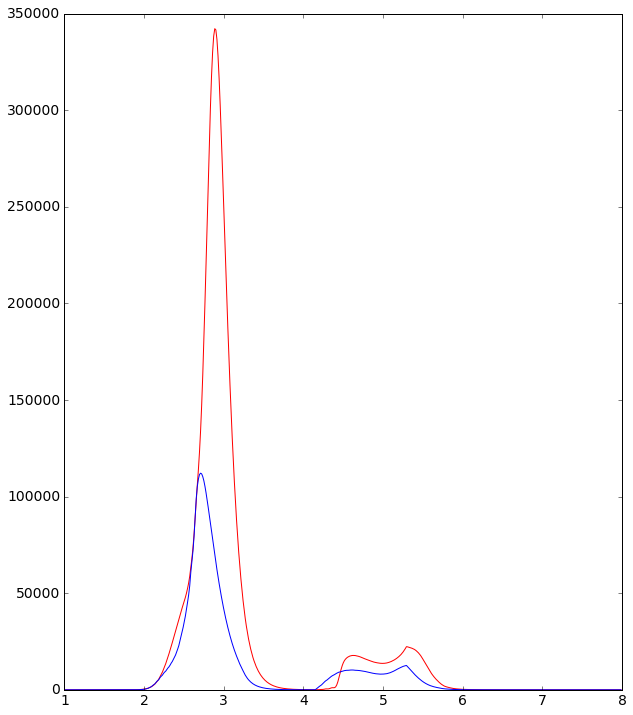

In [169]:
# Check if sum works out the same between different EA spacings:
L = 3
dir1 = '/Users/austin/FUSE/shared/users/asousa/WIPP/WIPPy/python/c/output/' 
dir2 = '/Users/austin/FUSE/shared/users/asousa/WIPP/WIPPy/python/c/output3/' 


phi_N1, phi_S1 = load_phi(dir1, L)
phi_N2, phi_S2 = load_phi(dir2, L)

plt.figure()
plt.plot(np.log10(sc.E_tot_arr), np.sum(phi_N1,axis=1),'r', np.log10(sc.E_tot_arr), np.sum(phi_N2,axis=1),'b')



In [156]:
freqs = np.arange(0,20)
def chunks(l, n):
    n = max(1, n)
    return [l[i:i + n] for i in range(0, len(l), n)]

# print freqs


nProcs = 2
nFreqs = np.shape(freqs)[0]

nSteps = np.floor(nFreqs/nProcs).astype(int)
print nSteps
chunks = [freqs[i:i+nSteps] for i in range(0, len(freqs), nSteps)]
print np.shape(chunks)

print chunks

print freqs
np.random.shuffle(freqs)
print freqs

10
(2, 10)
[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[17 11  6 16 14 13  4  3  9 15  1 18  0  7  5  2 12 19 10  8]
